In [ ]:
import lib.csv_helpers as csv
from IPython.display import display
import shutil

#Delete any existing dummy data
shutil.rmtree('dummydata')

## Generate Dummy Data
for testing / demo purposes.
Includes random surface chemistry mapping

In [ ]:
import lib.csv_helpers as csv
from IPython.display import display
import lib.json_setup as json_setup

print("Generating metadata run list with the following settings")

# Start with the example setup dictionary
setup = csv.get_default_setup()

run_df = csv.generate_run_df(setup)
run_df
# Iterate through the run_df calling dummy_measurement for each row,
# Stores the results in the path/subdirs defined in setup. 
# csv.run_measure(setup, run_df, measure_func=csv.dummy_measurement)


## Preview of csv spectrometer data
Simply displaying a csv measurement file with pandas

In [ ]:
import os
import pandas as pd

# pd.options.display.max_rows= 15
dir = "dummydata/instrument01/waterA/"
testfile = "instrument01-A01-waterA.txt"
df = pd.read_csv(os.path.join(dir, testfile), sep=',')

#label columns
reps = len(df.columns)-1
col_names = ['wavelength']
for r in range(reps):
	col_names.append(F"rep{r+1}")
df.columns = col_names
df

## Import from .txt or .csv files

### Input File

Requires a text file with at least 2 columns.
(They don't need to be named in the file)

[wavelength]	[transmission data 1]	...[transmission data n (optional)]

The default is for tab separation, but can be specified with:

separator = ','

### Regex
A regular expression must be provided to identify these Primary metadata fields from the filename:
* sensor
* element
* fluid

Optionally, extra fields can be identified, which will be added to the metadata:
* e.g. rotation


In [ ]:
import lib.csv_helpers as csv
import lib.json_setup as json_setup
import os 
os.chdir('/Users/calum/spectrometer/')

#Folder containing text/csv files to import

# CURRENTLY DOESNT SUPPORT TRM FORMAT
input_dir = "C:/Users/calum/spectrometer/s43729_example_raw"

# Construct a regex to extract metadata from the filename
# example 'HAN24_Sensor9_BeerBitter3_Rotation2.txt'
# regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(?P<rotation>.+).txt'
regex = '(?P<sensor>.+)_(?P<element>.+)_PreIDOT(?P<fluid>.+)__-.+Ep.trm'

# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/2022-08-02_s43729.json"
setup = json_setup.json_to_dict(setup_path)

csv.import_dir_to_csv(setup, input_dir, regex, separator=',')

# can save the new setup if anything has been changed
# json_setup.dict_to_json(setup, setup_path, overwrite=False)

## Example of searching by metadata

select_from_metadata() returns a list of h5 nodes that match the
criteria.

It can search a full h5 file, or if a nodelist is provided, it will work from
that.

Search criteria must include a metadata key, and can optionally include a
metadata value

In [ ]:
import lib.csv_helpers as csv
import os
import pandas as pd

setup = csv.get_default_setup()
os.chdir('/Users/calum/spectrometer/')

# meta_df = csv.read_metadata(setup)

# meta_df = csv.select_from_metadata('sensor', 'HAN24', meta_df)
# meta_df = csv.select_from_metadata('element', '01', meta_df)

dtypes = {
    'name'              : 'default_metadata_columns',
    # Column            : #Datatype
    'index'             : 'string',
    'date'              : 'datetime64[ns]',
    'instrument'        : 'string',
    'sensor'            : 'string',
    'element'           : 'string',
    'structure'         : 'string',
    'surface'           : 'string',
    'fluid'             : 'string',
    'repeats'           : 'Int64',
    'comment'           : 'string',
}
dtypes.pop('date')
dtypes.pop('name')

metapath = os.path.join(setup['datadir'], setup['metafile'])

meta_df = pd.read_csv(metapath,
                        sep=',',
                        index_col='index',
                        parse_dates=['date'],
                        dtype=dtypes,
                        keep_default_na = False
                        )

meta_df



## Export with Preprocessing

export_dataframes() takes a meta_df listing which measurements to export.
(In this case we select only fluid==Beer from the full set)

A DataProcessor object may also be passed, which will be applied to the
measurements during export.




INFO:root:filtering by metadata "fluid" == "Beer"
INFO:root:filtering by metadata "element" == "01"


fluid: Beer
element: 01
sensor: HAN24


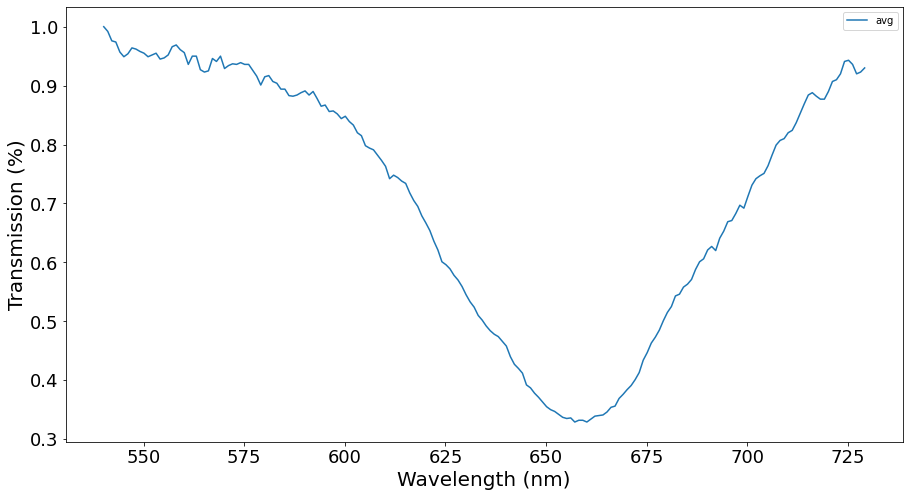

INFO:root:merging element 01
INFO:root:filtering by metadata "element" == "01"
INFO:root:Writing to export.txt ...
INFO:root:Done


Surface       <NA>                                                          \
Element         01                                                           
Wavelength 540.117 541.117 542.117 543.117 544.117 545.117 546.117 547.117   
avg            1.0   0.992   0.976   0.974   0.957   0.949   0.954   0.964   

Surface                     ...                                          \
Element                     ...                                           
Wavelength 548.117 549.117  ... 720.117 721.117 722.117 723.117 724.117   
avg          0.962   0.958  ...    0.89   0.907    0.91    0.92   0.941   

Surface                                             
Element                                             
Wavelength 725.117 726.117 727.117 728.117 729.117  
avg          0.943   0.936    0.92   0.923    0.93  

[1 rows x 190 columns]

In [3]:
import lib.csv_helpers as csv
import lib.data_process 
import lib.json_setup as json_setup

os.chdir('/Users/calum/spectrometer/')


# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

meta_df = csv.read_metadata(setup)
meta_df = csv.select_from_metadata('fluid', 'Beer', meta_df)
meta_df = csv.select_from_metadata('element', '01', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_avg_repeats = True
dp.apply_normalise = True
dp.apply_smooth = True
dp.apply_trim = True
dp.apply_interpolate = True
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1.0

merged_df, title = csv.merge_dataframes(setup, meta_df)

merged_df
df = dp.process_dataframe(merged_df)
print(title)

lib.data_process.plot(df)

export = csv.export_dataframes(setup, meta_df, dp=dp, outfile='export.txt')
export
# stats = csv.export_stats(setup, meta_df, dp=dp, outfile='export_stats.txt')
# stats


## Process and Plot data

In [ ]:
import lib.data_process
import os
import pandas as pd
import lib.csv_helpers as csv

setup = csv.get_default_setup()
meta_df = csv.read_metadata(setup)


dp = lib.data_process.DataProcessor()
dp.apply_interpolate = True
dp.apply_normalise = True
dp.apply_trim = True
dp.apply_smooth = True

meta_df = csv.select_from_metadata('sensor', 'DUM01', meta_df)

# meta_df = csv.select_from_metadata('element', '01', meta_df)

merged_df, title = csv.merge_dataframes(setup, meta_df)
df = dp.process_dataframe(merged_df)
print(title)
df

# lib.data_process.plot(df)


In [ ]:
import lib.csv_helpers as csv
import lib.data_process 
import lib.json_setup as json_setup

os.chdir('/Users/calum/spectrometer/')


# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)

meta_df = csv.read_metadata(setup)
meta_df = csv.select_from_metadata('fluid', 'Beer', meta_df)
# meta_df = csv.select_from_metadata('element', '02', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_normalise = True
dp.apply_smooth = False
dp.apply_trim = True
dp.apply_interpolate = False
dp.apply_round = True

dp.smooth_points = 1
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1

csv.export_stats(setup, dp, meta_df, outfile='stats.txt')



## Bulk Process
copy one dataset into another, can also be used for modifying a folder structure

In [ ]:
import os
import lib.csv_helpers as csv
import pandas as pd

path='./dummydata'
metapath = os.path.join(path, "index.txt")

setup_in = csv.get_default_setup()
setup_out = csv.get_default_setup()

setup_out['path'] = 'bulkmerge_output'
setup_out['subdirs'] = ['sensor', 'fluid']

csv.bulk_process(setup_in, setup_out, delete_input=False, merge_out=False)


## Single Measurements

Run some dummy measurements at various wavelengths to check they merge correctly

In [ ]:
import lib.csv_helpers as csv

setup = csv.get_default_setup()
element = 'A02'
fluid = 'asdf'

setup['wavelength_range'] = [400, 420, 0.5]
csv.simple_measurement(setup, element, fluid, csv.dummy_measurement)
setup['wavelength_range'] = [390, 410, 0.5]
df = csv.simple_measurement(setup, element, fluid, csv.dummy_measurement)
df




In [ ]:
import time
import numpy as np

# import the usb driver
import stellarnet_mac.stellarnet_driver3 as sn

import logging
logging.basicConfig(format='%(asctime)s %(message)s')

def getSpectrum(spectrometer, wav, inttime, scansavg, smooth):
    logging.warning('requesting spectrum')
    spectrometer['device'].set_config(int_time=inttime, scans_to_avg=scansavg, x_smooth=smooth)
    spectrometer['device'].print_info()
    spectrum = sn.array_spectrum(spectrometer, wav)
    logging.warning('recieved spectrum')
    return spectrum
    
spectrometer, wav = sn.array_get_spec(0)


       
inttime = 100
scansavg = 1
smooth = 1 

logging.warning('displaying spectrum')
data=getSpectrum(spectrometer, wav, inttime, scansavg, smooth)
data



In [ ]:
import pymongo

connection = pymongo.MongoClient('localhost', 27017)

database = connection['mydb_01']

collection = database['mycollection01']

data = {'name' : 'Calum'}

collection.insert_one(data)

collection.update_one

In [ ]:
import lib.csv_helpers as csv
import lib.json_setup as json_setup
import os
os.chdir('/Users/calum/spectrometer/')

#Folder containing text/csv files to import
input_dir = "/Users/calum/git/Glasgow/sampleData/combined"

# Construct a regex to extract metadata from the filename
# example 'HAN24_Sensor9_BeerBitter3_Rotation2.txt'
# regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(?P<rotation>.+).txt'
regex = '(?P<sensor>.+)_Sensor(?P<element>.+)_(?P<fluid>.+)_Rotation(.+).txt'

# setup = csv.get_default_setup()
setup_path = "/Users/calum/spectrometer/setup/HAN24.json"
setup = json_setup.json_to_dict(setup_path)
meta_df = csv.read_metadata(setup)
csv.write_meta_df_txt(setup, meta_df)
meta_df


# meta_df.to_csv(temp_buffer, index=True, sep='\t', na_rep='', date_format='%Y-%m-%d')
# temp_buffer.seek(0)
# temp_buffer.read()
# mod_df = pd.read_csv(temp_buffer,
#                         sep='\t',
#                         index_col='index',
#                         parse_dates=['date'],
#                         dtype=dtypes,
#                         keep_default_na = False
#                         )

# mod_df
# csv.import_dir_to_csv(setup, input_dir, regex)
# json_setup.dict_to_json(setup, setup_path, overwrite=False)

In [ ]:
import lib.csv_helpers as csv
import lib.data_process
os.chdir('/Users/calum/spectrometer/')


setup = csv.get_default_setup()
meta_df = csv.read_metadata(setup)
meta_df = csv.select_from_metadata('fluid', 'Beer', meta_df)
meta_df = csv.select_from_metadata('element', '01', meta_df)
# meta_df = csv.select_from_metadata('sensor', 'DUM01', meta_df)

dp = lib.data_process.DataProcessor()
dp.apply_normalise = True
dp.apply_smooth = True
dp.apply_trim = True
dp.apply_interpolate = True
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3
dp.interpolate_sampling_rate = 1.0

data = csv.merge_dataframes(setup, meta_df)
# data[0].iloc[:, :2]
df = data[0].iloc[:, :2]
lib.data_process.plot(df)

for col in df:
    if col == 'wavelength':
        pass
    else:
        baseline=df[col][1:101].mean()
        min = df[col][1:].min()
        height = baseline - min
        hm = min + (height/2)
        flagdown=0
        flagup=0
        for i in range(30,len(df[col])):
            value=df[col][i]
            if value<=hm and flagdown==0:
                flagdown=1
                side1=df['wavelength'][i]
            if value>=hm and flagdown==1 and flagup==0 and df['wavelength'][i]-side1>10:
                flagup=1
                side2=df['wavelength'][i]
            if flagup==1 and flagdown==1:
                break
        if flagup==0:
            side2=0
            side1=0
        fwhm_num=side2-side1
        print(f'{baseline=} {height=} {hm=} {fwhm_num}')

# export = csv.export_dataframes(setup, meta_df, dp=dp, outfile='export.txt')
# export

In [34]:
import lib.csv_helpers as csv
import lib.json_setup as json_setup
import math
import pandas as pd


def export_slide_rotation_csv(rotation_deg, pos_map, filepath):

    corr_map = pos_map.copy()
    # python uses radians by default
    rads = math.radians(rotation_deg)

    for element, coords in  pos_map.items():
        x=coords[0]
        y=coords[1]
        # # correct for rotation
        x = round(x*math.cos(rads) - y*math.sin(rads), 2)
        y = round(y*math.cos(rads) + x*math.sin(rads), 2)

        corr_map[element] = [x, y]

    print(corr_map)

    with open(filepath, 'w') as f:
        f.write(f'Angle = {slide_rotation} degrees\n')

        f.write(f'Element,X Orig,Y Orig,X Corrected,Y Corrected, X Adjustment,Y Adjustment\n')
        for key in pos_map.keys():
            x_orig = pos_map[key][0]
            y_orig = pos_map[key][1]
            x_corr = corr_map[key][0]
            y_corr = corr_map[key][1]
            x_adj = round(x_corr - x_orig, 5)
            y_adj = round(y_corr - y_orig, 5)
            f.write(f'{key},{x_orig},{y_orig},{x_corr},{y_corr},{x_adj},{y_adj}\n')


slide_rotation = -0.8 #degrees
setup_path = "/Users/calum/spectrometer/setup/default_setup.json"
setup = json_setup.json_to_dict(setup_path)
pos_map = setup['sensor']['layout']['map']
print(pos_map)

export_slide_rotation_csv(slide_rotation, pos_map, filepath='slide_rotation.csv')

{'A01': [1.5, 0], 'A02': [3.0, 0], 'B01': [1.5, -1.5], 'B02': [3.0, -1.5], 'C01': [1.5, -3.0], 'C02': [3.0, -3.0]}
{'A01': [1.5, -0.02], 'A02': [3.0, -0.04], 'B01': [1.48, -1.52], 'B02': [2.98, -1.54], 'C01': [1.46, -3.02], 'C02': [2.96, -3.04]}


In [29]:
round(-0.020000000000000018, 4)


-0.02